In [79]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os
from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from datetime import datetime, timedelta

from support.pd_support import *
from support.ar_calculations import *


from scipy.signal import savgol_filter
from scipy import integrate
from ahrs.filters import Madgwick

from scipy.signal import savgol_filter

from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

In [80]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "validation"
_calib_folder_name = "calibration_00"

# _folder_name = "ar_30_5_quad_random_slow_01"
_folder_name = "skimu3_30_4_random_1m_0"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "webcam_rotmat_validation_imu_4.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)

In [171]:
timeoffset = 0.0
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)
_raw_imu_df = pl.read_csv(_imu_pth)

dt = _imu_df["mils"].diff().mean()/1000
dt = 0.011
filter_size = 51
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter
_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])

_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).alias("time"))

#change string to float
_imu_df = _imu_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))

In [172]:
_raw_imu_df = _raw_imu_df[["mils", "gx", "gy", "gz", "ax", "ay", "az", 'mx','my',"mz\r"]]
_raw_imu_df = _raw_imu_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))

In [186]:
# apply savgol filter
_raw_imu_df = _raw_imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("gx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("gy").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("gz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("mx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("my").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("mz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                    ])

_raw_imu_df = _raw_imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

In [173]:
madgwick = Madgwick(acc = _raw_imu_df[["ax", "ay", "az"]].to_numpy(), gyr = _raw_imu_df[["gx", "gy", "gz"]].to_numpy(), mag = _raw_imu_df[["mx", "my", "mz"]].to_numpy(),frequency=1/dt)

In [174]:
_d_r = R.from_quat(madgwick.Q)

In [175]:
_d_r.as_matrix()
_del_r = []
for i in tqdm(range(len(_d_r.as_matrix()))):
    _del_r.append(_d_r.as_matrix()[i].T@_d_r.as_matrix()[0])
    
_del_r = np.array(_del_r)
rotmat = R.from_matrix(_del_r)

  0%|          | 0/9357 [00:00<?, ?it/s]

100%|██████████| 9357/9357 [00:00<00:00, 11183.40it/s]


In [178]:
euler = _d_r.as_euler('zyx', degrees=True)
theta_x = euler[:,0]
theta_y = euler[:,1]
theta_z = euler[:,2]

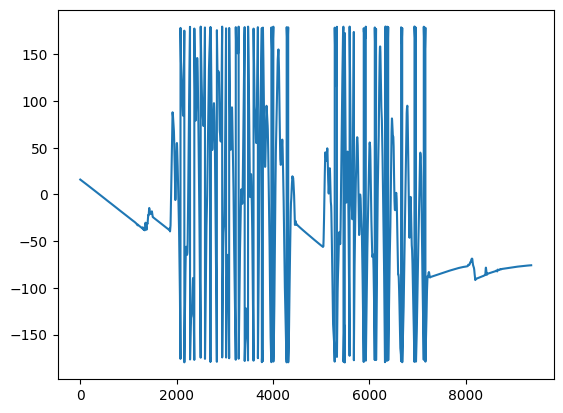

In [183]:
plt.plot(theta_z)

In [192]:
newr = R.from_euler('zyx', _raw_imu_df[['ang_z', 'ang_y', 'ang_x']].to_numpy(), degrees=True)
quat = newr.as_quat()

In [193]:
quat[0]

array([-5.69513983e-05, -7.12938165e-06,  2.03884916e-05,  9.99999998e-01])

In [194]:
madgwick.Q[0]

array([ 0.00112693, -0.13908949,  0.99008094, -0.01981374])